In [1]:
import logging
import yaml

import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import asyncio

# import palpy

from lsst.ts import salobj

from lsst.ts.standardscripts.auxtel.attcs import ATTCS

from lsst.ts.idl.enums import ATPtg

%matplotlib inline

In [2]:
from astropy.utils import iers
iers.conf.auto_download = False

In [3]:
d = salobj.Domain()

In [4]:
atmcs = salobj.Remote(d, "ATMCS")
atptg = salobj.Remote(d, "ATPtg")
ataos = salobj.Remote(d, "ATAOS")
atpne = salobj.Remote(d, "ATPneumatics")
athex = salobj.Remote(d, "ATHexapod")
atdome = salobj.Remote(d, "ATDome", index=1)
atdomtraj = salobj.Remote(d, "ATDomeTrajectory")

In [5]:
await asyncio.gather(atmcs.start_task, 
                     atptg.start_task,
                     ataos.start_task,
                     atpne.start_task,
                     athex.start_task,
                     atdome.start_task,
                     atdomtraj.start_task)

AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 10 messages


[None, None, None, None, None, None, None]

# ATMCS

In [ ]:
await asyncio.sleep(5.)
print("Done")
await salobj.set_summary_state(atmcs, salobj.State.ENABLED)

# ATPtg

In [ ]:
await asyncio.sleep(5.)
print("Done")
await atptg.tel_timeAndDate.next(flush=True, timeout=5)
await salobj.set_summary_state(atptg, salobj.State.ENABLED)

In [ ]:
await atptg.cmd_azElTarget.set_start(azDegs=243., elDegs=80.)

In [ ]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [ ]:
ra = Angle("03:02:16.77307", unit=u.hour)
dec = Angle("+04:05:23.0596", unit=u.deg)
target_name="Alf Cet"
radec = ICRS(ra, dec)


In [ ]:
await atmcs.cmd_stopTracking.start()

In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [ ]:
# Figure out what is the rotPA that sets nasmith rotator close to zero.
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
print(curr_time_atptg)
coord_frame_altaz = AltAz(location=location, obstime=curr_time_atptg)
alt_az = radec.transform_to(coord_frame_altaz)

print("slew...")
# await atmcs.cmd_startTracking.start(timeout=10)
await atptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    targetInstance=ATPtg.TargetInstances.CURRENT,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=radec.ra.hour,
    declination=radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=180.-alt_az.alt.deg,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [ ]:
ss = await atdome.evt_summaryState.next(flush=False, timeout=5)

In [ ]:
print(salobj.State(ss.summaryState))

In [ ]:
ss = await atdomtraj.evt_summaryState.next(flush=False, timeout=5)

In [ ]:
print(salobj.State(ss.summaryState))

In [ ]:
await atdomtraj.cmd_enable.start()

In [6]:
async def wait_center():
    while True:
        opt = input("Center telescope and choose action (press ?<enter>, for list of actions): ")
        
        if opt == 'n':
            print("Next point in the grid...")
            return 1
        elif opt == 'p':
            print("Previous point in the grid...")
            return -1
        elif opt == 't':
            print("Stopping test...")
            return 0
        elif opt == '?':
            print("""Options are:
            n - Go to next point in the grid.
            p - Go to previous point in the grid.
            t - Terminate test.
            """)
        else:
            print("Next point in the grid...")
            return 1

In [7]:
dalt_grid = np.arange(-0.25, +0.255, 0.05)
daz_grid = np.arange(-0.25, +0.255, 0.05)

In [ ]:
await atptg.cmd_offsetAzEl.set_start(el=0.45*60.*60., 
                                     az=-0.35*60*60, 
                                         num=0)

In [8]:
grid_alt = np.zeros(len(dalt_grid)*len(daz_grid))
grid_az = np.zeros(len(dalt_grid)*len(daz_grid))

for i in range(len(daz_grid)):
    grid_alt[i*len(dalt_grid):(i+1)*len(dalt_grid)] += dalt_grid[::(-1)**i]
    grid_az[i*len(dalt_grid):(i+1)*len(dalt_grid)] += daz_grid[i]

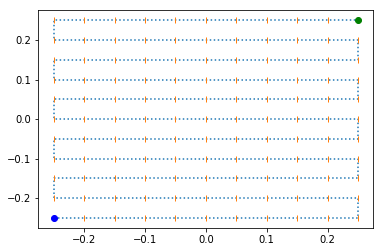

In [9]:
plt.plot(grid_alt, grid_az, ':')
plt.plot(grid_alt, grid_az, '|')
plt.plot(grid_alt[0], grid_az[0], 'bo')
plt.plot(grid_alt[-1], grid_az[-1], 'go')

In [10]:
start_from=0

In [12]:
await atptg.cmd_offsetAzEl.set_start(el=0., 
                                     az=0., 
                                     num=0)

falling behind; queue contains 92 elements
falling behind; queue contains 91 elements
falling behind; queue contains 90 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 39 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


In [16]:
print(f"Grid has {len(grid_alt)} pointings...")
print(f"Starting from {start_from}")

i = start_from
stop_at = 0

while i < len(grid_alt):
    
    print(f"GRID[{i}]: {grid_alt[i]} x {grid_az[i]}")

    await atptg.cmd_offsetAzEl.set_start(el=grid_alt[i]*60.*60., 
                                         az=grid_az[i]*60*60, 
                                         num=0)
    
    ret_val = await wait_center()

    if ret_val == 0:
        break
        
    i += ret_val
    
    if i < 0:
        print(f"Unwrapping index! (i={i})")
        i = 0

RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 38 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 38 messages


Grid has 121 pointings...
Starting from 0
GRID[0]: -0.25 x -0.25


AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 92 messages
falling behind; queue contains 91 elements
falling behind; queue contains 90 elements
RemoteTelemetry(ATMCS, 0, measuredTorque) falling behind; read 38 messages
RemoteTelemetry(ATMCS, 0, measuredMotorVelocity) falling behind; read 38 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 51 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 50 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 50 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 50 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 50 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 50 messages


Next point in the grid...
GRID[1]: -0.2 x -0.25


RemoteTelemetry(ATPtg, 0, currentTimesToLimits) falling behind; read 11 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 51 messages
RemoteEvent(ATPneumatics, 0, heartbeat) falling behind; read 51 messages
falling behind; queue contains 22 elements


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATDome, 1, position) falling behind; read 10 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[2]: -0.15000000000000002 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[3]: -0.10000000000000003 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 14 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[4]: -0.050000000000000044 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 79 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 19 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[5]: -5.551115123125783e-17 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 65 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 16 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 16 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 16 messages


Next point in the grid...
GRID[6]: 0.04999999999999993 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 69 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[7]: 0.09999999999999992 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 15 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 36 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 36 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[8]: 0.1499999999999999 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATDome, 1, position) falling behind; read 91 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 15 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 18 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 18 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 18 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 92 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 18 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 18 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 14 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 92 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 28 messages
RemoteEvent(ATPneumatics, 0, m1SetPressure) falling behind; read 15 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements

Next point in the grid...
GRID[9]: 0.1999999999999999 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 14 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 27 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 27 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 27 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[10]: 0.2499999999999999 x -0.25


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 22 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[11]: 0.2499999999999999 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 27 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 27 messages
falling behind; queue contains 13 elements


Next point in the grid...
GRID[12]: 0.1999999999999999 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 84 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[13]: 0.1499999999999999 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 19 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 79 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 19 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[14]: 0.09999999999999992 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 52 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 13 messages


Next point in the grid...
GRID[15]: 0.04999999999999993 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 75 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[16]: -5.551115123125783e-17 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 97 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 10 messages


Next point in the grid...
GRID[17]: -0.050000000000000044 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 67 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[18]: -0.10000000000000003 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 17 elements


Next point in the grid...
GRID[19]: -0.15000000000000002 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 91 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 10 elements


Next point in the grid...
GRID[20]: -0.2 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 58 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[21]: -0.25 x -0.2


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 53 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[22]: -0.25 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[23]: -0.2 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 56 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 14 messages


Next point in the grid...
GRID[24]: -0.15000000000000002 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 58 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[25]: -0.10000000000000003 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 79 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 19 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 19 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 19 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[26]: -0.050000000000000044 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 17 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 17 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 71 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[27]: -5.551115123125783e-17 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 57 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 14 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 14 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 14 messages


Next point in the grid...
GRID[28]: 0.04999999999999993 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATDome, 1, position) falling behind; read 21 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 84 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 21 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 11 messages
falling behind; queue contains 10 elements


Next point in the grid...
GRID[29]: 0.09999999999999992 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 90 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[30]: 0.1499999999999999 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 20 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 40 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 41 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[31]: 0.1999999999999999 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 57 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[32]: 0.2499999999999999 x -0.15000000000000002


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 55 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 13 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 14 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[33]: 0.2499999999999999 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 78 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 20 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 19 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 20 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 20 messages


Next point in the grid...
GRID[34]: 0.1999999999999999 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 47 messages


Next point in the grid...
GRID[35]: 0.1499999999999999 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 76 messages


Next point in the grid...
GRID[36]: 0.09999999999999992 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 52 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[37]: 0.04999999999999993 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 63 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 15 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 16 messages


Next point in the grid...
GRID[38]: -5.551115123125783e-17 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 61 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 15 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 15 messages


Next point in the grid...
GRID[39]: -0.050000000000000044 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 84 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 20 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[40]: -0.10000000000000003 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 98 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 24 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 12 messages
falling behind; queue contains 11 elements


Next point in the grid...
GRID[41]: -0.15000000000000002 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 97 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 11 elements


Next point in the grid...
GRID[42]: -0.2 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 98 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 24 messages
falling behind; queue contains 11 elements


Next point in the grid...
GRID[43]: -0.25 x -0.10000000000000003


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 74 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[44]: -0.25 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 34 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 10 messages
falling behind; queue contains 14 elements


Next point in the grid...
GRID[45]: -0.2 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 77 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 19 messages


Next point in the grid...
GRID[46]: -0.15000000000000002 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 45 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 11 messages


Next point in the grid...
GRID[47]: -0.10000000000000003 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 11 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 92 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 22 messages


Next point in the grid...
GRID[48]: -0.050000000000000044 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 39 messages
falling behind; queue contains 18 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 40 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 40 messages


Next point in the grid...
GRID[49]: -5.551115123125783e-17 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 27 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 11 elements


Next point in the grid...
GRID[50]: 0.04999999999999993 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 65 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[51]: 0.09999999999999992 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 76 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 19 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 19 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 19 messages


Next point in the grid...
GRID[52]: 0.1499999999999999 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 70 messages


Next point in the grid...
GRID[53]: 0.1999999999999999 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 53 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[54]: 0.2499999999999999 x -0.050000000000000044


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 71 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 18 messages


Next point in the grid...
GRID[55]: 0.2499999999999999 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 50 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[56]: 0.1999999999999999 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 89 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 10 elements


Next point in the grid...
GRID[57]: 0.1499999999999999 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 54 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 13 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[58]: 0.09999999999999992 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 84 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 21 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 21 messages


Next point in the grid...
GRID[59]: 0.04999999999999993 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 91 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 11 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 23 messages


Next point in the grid...
GRID[60]: -5.551115123125783e-17 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 59 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[61]: -0.050000000000000044 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 14 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[62]: -0.10000000000000003 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 17 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[63]: -0.15000000000000002 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 53 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 13 messages


Next point in the grid...
GRID[64]: -0.2 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 22 messages


Next point in the grid...
GRID[65]: -0.25 x -5.551115123125783e-17


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 87 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 12 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 21 messages
falling behind; queue contains 11 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[66]: -0.25 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 44 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[67]: -0.2 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATDome, 1, position) falling behind; read 14 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 59 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[68]: -0.15000000000000002 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 60 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 15 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[69]: -0.10000000000000003 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 11 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[70]: -0.050000000000000044 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 61 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 15 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 15 messages


Next point in the grid...
GRID[71]: -5.551115123125783e-17 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 77 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 19 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[72]: 0.04999999999999993 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 56 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[73]: 0.09999999999999992 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 13 messages
falling behind; queue contains 12 elements


Next point in the grid...
GRID[74]: 0.1499999999999999 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 64 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 16 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 16 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[75]: 0.1999999999999999 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 54 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 13 messages


Next point in the grid...
GRID[76]: 0.2499999999999999 x 0.04999999999999993


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 84 messages
falling behind; queue contains 10 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[77]: 0.2499999999999999 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 57 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[78]: 0.1999999999999999 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 11 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 50 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 11 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 10 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 11 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 11 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 10 messages
falling behind; queue contains 24 elements


Next point in the grid...
GRID[79]: 0.1499999999999999 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 18 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 39 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 38 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 39 messages


Next point in the grid...
GRID[80]: 0.09999999999999992 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 71 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 17 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 18 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 18 messages


Next point in the grid...
GRID[81]: 0.04999999999999993 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 26 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 25 messages
RemoteEvent(ATPneumatics, 0, m1SetPressure) falling behind; read 26 messages


Next point in the grid...
GRID[82]: -5.551115123125783e-17 x 0.09999999999999992


AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 78 messages
falling behind; queue contains 77 elements
falling behind; queue contains 76 elements


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 31 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 32 messages
falling behind; queue contains 14 elements


Next point in the grid...
GRID[83]: -0.050000000000000044 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 17 elements
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 39 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 39 messages


Next point in the grid...
GRID[84]: -0.10000000000000003 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 61 messages
falling behind; queue contains 29 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 12 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 10 messages


Next point in the grid...
GRID[85]: -0.15000000000000002 x 0.09999999999999992


Center telescope and choose action (press ?<enter>, for list of actions):  t


Stopping test...


In [15]:
await atptg.cmd_offsetAzEl.set_start(el=0., 
                                     az=-100, 
                                     num=0)

RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 12 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 60 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 12 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 12 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATPneumatics, 0, m1SetPressure) falling behind; read 10 messages
falling behind; queue contains 97 elements
falling behind; queue contains 96 elements
falling behind; queue contains 95 elements


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


In [ ]:
await atptg.cmd_offsetAzEl.set_start(el=-15., 
                                     az=0, 
                                         num=1)

In [ ]:
60-61

In [ ]:
await asyncio.sleep(5)
off = await atptg.tel_guidingAndOffsets.next(flush=True, timeout=5)

In [ ]:
print(off)